# Homework 4: The Structure of Stellar Remnants

I will use my ODE package from HW 3 to solve this problem set.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.constants as const

import sys
sys.path.append("../HW3/")
from ode import euler, heun, RK4

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

Define constants used in the appropriate units.

In [2]:
G = const.G.cgs.value
c = const.c.cgs.value
csq = c**2
R_earth = const.R_earth.to(u.cm).value
M_sun = const.M_sun.to(u.g).value

r_step = 200 #number of radial steps to integrate
rho_step = 21 #number of steps in rho_c to perform.

-----

## Q1: 

For central densities in the range $\rho_c = 10^4 - 10^6$ g/cm$^3$, solve via your RK4 solver the hydrostatic
equilibrium equations above for white dwarfs and plot the mass-radius curve. That is, chose a central
density. You will then integrate over radial slices $dr$, and once you have $M$ and $R$, you will store that and
move onto the next central density. Since you are feeding your solver a list of radial slices to solve at, you
can either determine some stopping criterion internally or just give the code a list of slices out to a few
$R_\odot$ (since we know that white dwarfs can't be much larger than this), thereby ensuring that you will hit
$P \approx 0$ somewhere in the array. Once you have your whole list of $M$s and $R$s, plot $M$ versus $R$ and that is
the mass-radius curve.

First I will define relationships between $\rho$ and $P$ out of convenience, and using `astropy` units.

In [3]:
prefactor = ((1.0/20) * (3/np.pi)**(2.0/3) * const.h**2 / (const.m_e * const.u**(5.0/3))).cgs

def rho_to_P(rho, mu_e=2):
    return (prefactor * ((rho*u.g/u.cm**3)/mu_e)**(5.0/3)).to(u.Ba).value

def P_to_rho(P, mu_e=2):
    return ((P*u.Ba / prefactor)**(3.0/5) * mu_e).to(u.g/u.cm**3).value

In [4]:
def dPdr(r, P, M_enc):
    if M_enc == 0:
        return 0.0 #derivative at the interior is dP/dr = 0
    rho = P_to_rho(P)
    #print(rho)
    return -G*M_enc*rho/r**2

def dM_encdr(r, P, M_enc):
    rho = P_to_rho(P)
    return 4*np.pi*r**2*rho

Here we'll show a single iteration based on initial conditions and plot the results of the integration.

In [5]:
# Initial conditions
M_enc0 = 0 
rho0 = 1e4 #g/cm^-3
P0 = rho_to_P(rho0)

In [6]:
# Perform the integration
Rs = np.linspace(0, 5*R_earth, r_step)
Ps, M_encs = RK4(Rs, dPdr, P0, dM_encdr, M_enc0)

/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


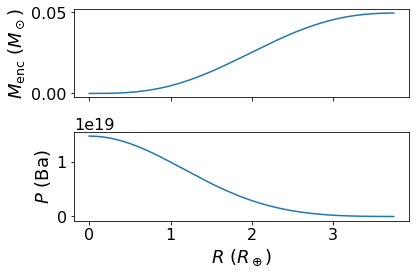

In [7]:
# Plot P and M_enc versus radius
ax1 = subplot(211)
ax1.plot(Rs/R_earth, M_encs/M_sun)
ax1.set_ylabel(r'$M_{\rm enc}~(M_\odot)$')
ax1.set_xticklabels([])
ax2 = subplot(212)
ax2.plot(Rs/R_earth, Ps)
ax2.set_xlabel(r'$R~(R_\oplus)$')
ax2.set_ylabel(r'$P~({\rm Ba})$')
tight_layout()

For ease, I have written a function that will return the total mass and radius found after performing the integration.

In [8]:
def get_mass_radius(Rs, Ps, M_encs):
    """
    Given the results of the ODE output, find when the pressure hits NaN
    to find the total mass of the object and its radius
    
    Parameters
    ----------
    Rs : np.ndarray
        Input radii to the ODE solver
    Ps : np.ndarray
        Output pressures from the ODE solver
    M_encs : np.ndarray
        Output enclosed masses from the ODE solver
    
    Returns
    -------
    mass : float
        Total mass of the object
    radius : float
        Total radius of the object
    """
    inds = np.where(np.logical_not(np.isnan(Ps)))[0] # indices of all non-NAN values
    return M_encs[inds][-1], Rs[inds][-1] # Last value of the non-NAN values

You can see that this solution is quite poor compared to the solution via `odeint()`. However, if I up the number of timesteps, I get a much better solution.

In [9]:
M_enc0 = 0 
Rs = np.linspace(0, 5*R_earth, r_step)
rho0s = np.logspace(4, 6, rho_step) #g/cm^3

masses = np.zeros(len(rho0s)) #save the outputs in these
radii = np.zeros(len(rho0s))

for i, rho0 in enumerate(rho0s):
    P0 = rho_to_P(rho0)
    # Perform the integration
    Ps, M_encs = RK4(Rs, dPdr, P0, dM_encdr, M_enc0)
    M, R = get_mass_radius(Rs, Ps, M_encs)
    masses[i] = M/M_sun
    radii[i] = R/R_earth


/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Below is the mass-radius plot:

Text(0.5, 0, '$R~(R_\\oplus)$')

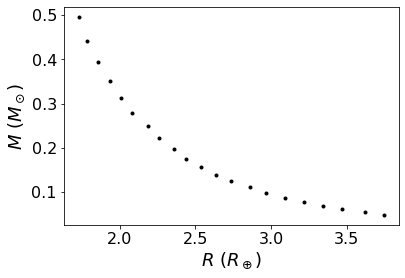

In [10]:
plot(radii, masses, 'k.')
ylabel(r'$M~(M_\odot)$')
xlabel(r'$R~(R_\oplus)$')

If we plot it on a log-log scale, we see that it follows a linear trend, which is what we expect from the $M-R$ relation in the non-relativistic regime below the Chandrasekhar mass.

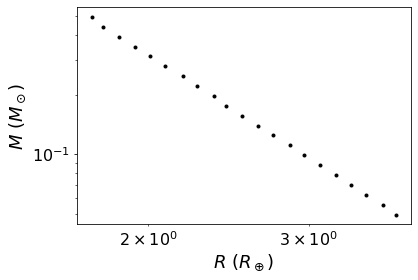

In [11]:
plot(radii, masses, 'k.')
ylabel(r'$M~(M_\odot)$')
xlabel(r'$R~(R_\oplus)$')
xscale('log')
yscale('log')

-----

## Q2:

For central densities in the range $\rho_c = 10^{14} - 10^{16}$ g/cm$^{3}$, solve the relativistic hydrostatic equilibrium equations above for neutron stars and plot the mass-radius curve. In this case, your slices only need
to go out to maybe 20 km.


We can use the same machinery as above except that in this case, we have to program the TOV equations for the $dP/dr$ relation.

In [12]:
prefactor = ((1.0/20) * (3/np.pi)**(2.0/3) * const.h**2 / const.m_n**(8.0/3)).cgs

def rho_to_P(rho):
    return (prefactor * (rho*u.g/u.cm**3)**(5.0/3)).to(u.Ba).value

def P_to_rho(P):
    return ((P*u.Ba / prefactor)**(3.0/5)).to(u.g/u.cm**3).value

In [13]:
def dPdr_TOV(r, P, M_enc):
    if M_enc == 0:
        return 0.0 #derivative at the interior is dP/dr = 0
    rho = P_to_rho(P)
    # Define each of the four terms separately for readability
    A = -G*M_enc*rho/r**2
    B = 1 + P/(rho*csq)
    C = 1 + 4*np.pi*r**3*P/(M_enc*csq)
    D = (1 - 2*G*M_enc/(r*csq))**-1
    return A*B*C*D

def dM_encdr(r, P, M_enc): #this is the same as previously
    rho = P_to_rho(P)
    return 4*np.pi*r**2*rho

Again, let's look at one of iteration

In [14]:
# Initial conditions
M_enc0 = 0 
rho0 = 1e14 #g/cm^-3
P0 = rho_to_P(rho0)

In [15]:
# Perform the integration
km = 1e5 # km ->cm
Rs = np.linspace(0, 50*km, r_step)
Ps, M_encs = RK4(Rs, dPdr_TOV, P0, dM_encdr, M_enc0)

/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


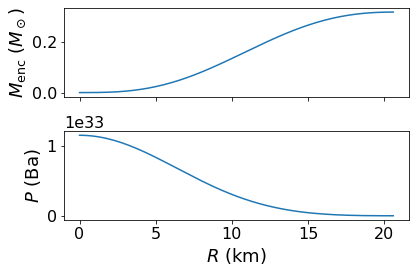

In [16]:
# Plot P and M_enc versus radius
ax1 = subplot(211)
ax1.plot(Rs/km, M_encs/M_sun)
ax1.set_ylabel(r'$M_{\rm enc}~(M_\odot)$')
ax1.set_xticklabels([])
ax2 = subplot(212)
ax2.plot(Rs/km, Ps)
ax2.set_xlabel(r'$R~({\rm km})$')
ax2.set_ylabel(r'$P~({\rm Ba})$')
tight_layout()

We can see that everything is working pretty much as we expect. Therefore, let's go through and get the mass-radius diagram.

In [17]:
M_enc0 = 0 
Rs = np.linspace(0, 50*km, r_step)
rho0s = np.logspace(14, 16, rho_step) #g/cm^3

masses = np.zeros(len(rho0s)) #save the outputs in these
radii = np.zeros(len(rho0s))

for i, rho0 in enumerate(rho0s):
    P0 = rho_to_P(rho0)
    # Perform the integration
    Ps, M_encs = RK4(Rs, dPdr_TOV, P0, dM_encdr, M_enc0)
    M, R = get_mass_radius(Rs, Ps, M_encs)
    masses[i] = M/M_sun
    radii[i] = R/km


/usr/local/lib/python3.6/dist-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, '$R~({\\rm km})$')

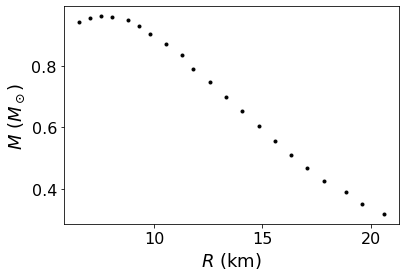

In [18]:
plot(radii, masses, 'k.')
ylabel(r'$M~(M_\odot)$')
xlabel(r'$R~({\rm km})$')

In this case, we can see a bit of a turnover, which is characteristic of many nucleon-based $M-R$ relations for neutron stars. However, we note that this line does seem to deviate a bit where the "canonical" pulsar, a 1.4 $M_\odot$, $R  = 12$ km object, is concerned.

-----

## Q3:

The Neutron Star Interior Composition Explorer (NICER) measured the radius and mass of PSR J0030+0451 to be $R = 13.02_{-1.06}^{+1.24}$~km and $M = 1.44_{-0.14}^{+0.15} M_\odot$, respectively. Numerically calculate the expected mass of a neutron star with an equation of state governed by the TOV equation and with a radius of 13.02 km. It will likely not be as observed!

I will interpolate the line using `scipy` rather than my own code just for reference on how that can be used.

In [19]:
f = interp1d(radii, masses)
R_J0030 = 13.02
M_J0030 = f(R_J0030)
print("Predicted Mass of PSR J0030+0451: %0.2f M_sun"%M_J0030)

Predicted Mass of PSR J0030+0451: 0.72 M_sun


As expected, our predicted mass of the pulsar differs from observations, indicating that the TOV equation is an _incomplete_ description of the equation of state for a neutron star.